In [1]:
import numpy as np
import pandas as pd

import json
import itertools
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from matplotlib import pyplot as plt
import seaborn as sns

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import util

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Pull Spotify Data

In [2]:
CLIENT_ID="810e2eec841546269c49f338f1be189a"
CLIENT_SECRET="764290d0ab0f4f4484b0d4c7b701bdee"

token = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

cache_token = token.get_access_token()
sp = spotipy.Spotify(cache_token)

In [3]:
# Pull data
TRACK_DATA_PATH = "data/tracks.json"
with open(TRACK_DATA_PATH,'r') as ff:
    songs = json.load(ff)
    
# Remove duplicates
songs.sort()
songs = list(s for s,_ in itertools.groupby(songs))
print("Loaded {} songs from {}".format(len(songs), TRACK_DATA_PATH))
print("First ten songs: {}".format(songs[:10]))

Loaded 6686 songs from data/tracks.json
First ten songs: [['002QT7AS6h1LAF5dla8D92', 'Still Smell Like It', 56], ['003eoIwxETJujVWmNFMoZy', 'Growing Pains', 72], ['00B7TZ0Xawar6NZ00JFomN', 'Best Life (feat. Chance The Rapper)', 70], ['00Fboe8pNoWHLg1nn3e7Oi', 'Sands Of Time (Single Version) - Remastered', 0], ['00GL3XaK1sBpnB2eaam9SG', 'Ghost Town', 42], ['00I0pcNkN3IOX3fsYbaB4N', 'Infatuation', 69], ['00KjOnN3U40e3lXFUOue7h', '10AM/Save The World (feat. Gucci Mane)', 61], ['00Y9yFHumsN6Cg4cK3wXkM', 'Cap (feat. Trouble) - From Jxmtro', 51], ['00bWqt93aqLXqKtzZoq7Jw', 'MOOO!', 69], ['00ix2WCV1QGcrcVGliKJYY', 'Photograph - Felix Jaehn Remix', 28]]


## Data Exploration

/Users/etang/dev/SoundScorer221/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


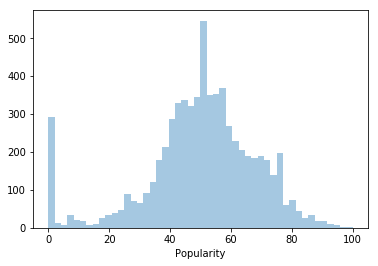

In [94]:
# Plot popularity distribution
sns.distplot([s[2] for s in songs], rug=False, kde=False, axlabel="Popularity")

In [4]:
# Extract top 5 most popular songs
sorted(songs, key=lambda song: song[2])[-10:]

[['2LskIZrCeLxRvCiGP8gxlh', 'Arms Around You (feat. Maluma & Swae Lee)', 94],
 ['3EPXxR3ImUwfayaurPi3cm', 'Be Alright', 94],
 ['3ee8Jmje8o58CHK66QrVC2', 'SAD!', 94],
 ['4S8d14HvHb70ImctNgVzQQ', 'I Love It (& Lil Pump)', 94],
 ['0d2iYfpKoM0QCKvcLCkBao', 'Eastside (with Halsey & Khalid)', 95],
 ['5N5k9nd479b1xpDZ4usjrg', 'Promises (with Sam Smith)', 95],
 ['2xLMifQCjDGFmkHkpNLD9h', 'SICKO MODE', 96],
 ['5p7ujcrUXASCNwRaWNHR1C', 'Without Me', 96],
 ['2dpaYNEQHiRxtZbfNsse99', 'Happier', 98],
 ['4w8niZpiMy6qz1mntFA5uM',
  'Taki Taki (with Selena Gomez, Ozuna & Cardi B)',
  100]]

## Feature Extraction

In [5]:
# audio_features provides high-level Echo Nest features
sp.audio_features(songs[0][0])

[{'acousticness': 0.0469,
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/002QT7AS6h1LAF5dla8D92',
  'danceability': 0.83,
  'duration_ms': 207827,
  'energy': 0.653,
  'id': '002QT7AS6h1LAF5dla8D92',
  'instrumentalness': 0,
  'key': 1,
  'liveness': 0.112,
  'loudness': -5.298,
  'mode': 1,
  'speechiness': 0.185,
  'tempo': 123.032,
  'time_signature': 4,
  'track_href': 'https://api.spotify.com/v1/tracks/002QT7AS6h1LAF5dla8D92',
  'type': 'audio_features',
  'uri': 'spotify:track:002QT7AS6h1LAF5dla8D92',
  'valence': 0.228}]

In [6]:
''' Returns a list of each track's audio features'''
def features(songs):
    all_feats = []
    ids = [song[0] for song in songs]
    # Spotify's audio_features can only return 50 songs at once
    for i in range(0, len(songs), 50):
        track_feats = sp.audio_features(ids[i:i+50])
        for j in range(len(track_feats)):
            if not track_feats[j]:
                continue # song not found in Spotify
            track_feats[j]['name'] = songs[i+j][1]
            track_feats[j]['popularity'] = songs[i+j][2]
        all_feats.extend(filter(None, track_feats))
    return all_feats

In [7]:
feats = features(songs)
feats[100]

{'acousticness': 0.301,
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/07VizkUweZe2lQo4yWIhgA',
 'danceability': 0.598,
 'duration_ms': 212482,
 'energy': 0.559,
 'id': '07VizkUweZe2lQo4yWIhgA',
 'instrumentalness': 0,
 'key': 4,
 'liveness': 0.263,
 'loudness': -7.534,
 'mode': 0,
 'name': "해장국 Hero's Soup",
 'popularity': 58,
 'speechiness': 0.0616,
 'tempo': 171.851,
 'time_signature': 4,
 'track_href': 'https://api.spotify.com/v1/tracks/07VizkUweZe2lQo4yWIhgA',
 'type': 'audio_features',
 'uri': 'spotify:track:07VizkUweZe2lQo4yWIhgA',
 'valence': 0.0922}

In [9]:
data = pd.DataFrame(feats)
data = data.sample(frac=1)
data.head()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,time_signature,track_href,type,uri,valence
4667,0.93100,https://api.spotify.com/v1/audio-analysis/5SMa...,0.0636,425173,0.141,5SMaPs9KzZSn2tn4VxZbXp,0.875000,2,0.0543,-21.424,0,"Chromatic Fantasia & Fugue in D Minor, BWV 903...",0,0.0370,65.169,5,https://api.spotify.com/v1/tracks/5SMaPs9KzZSn...,audio_features,spotify:track:5SMaPs9KzZSn2tn4VxZbXp,0.0398
6132,0.04000,https://api.spotify.com/v1/audio-analysis/7A5z...,0.5460,113853,0.366,7A5zSSX7AAVRhcTmIaKcf6,0.087700,0,0.0568,-9.919,1,When Gloves Come Off (feat. Ryan Beatty),0,0.0324,83.970,4,https://api.spotify.com/v1/tracks/7A5zSSX7AAVR...,audio_features,spotify:track:7A5zSSX7AAVRhcTmIaKcf6,0.1530
4659,0.91500,https://api.spotify.com/v1/audio-analysis/5RmA...,0.4270,77327,0.401,5RmAMSIl5JmcygqbSEWshc,0.000002,1,0.4550,-17.269,1,It's In Your Hands (with Mike WiLL Made-It),35,0.4760,129.282,5,https://api.spotify.com/v1/tracks/5RmAMSIl5Jmc...,audio_features,spotify:track:5RmAMSIl5JmcygqbSEWshc,0.5940
1302,0.85700,https://api.spotify.com/v1/audio-analysis/1T57...,0.5520,191787,0.371,1T575AhHueYinKSDflEsGK,0.000000,7,0.0838,-9.104,0,Heaven,77,0.0359,199.843,3,https://api.spotify.com/v1/tracks/1T575AhHueYi...,audio_features,spotify:track:1T575AhHueYinKSDflEsGK,0.2450
5189,0.00261,https://api.spotify.com/v1/audio-analysis/66Mp...,0.7480,190999,0.630,66MpvsWO5O7gy9LjXGFw6I,0.859000,6,0.5320,-7.318,0,Maria También,52,0.0460,103.597,4,https://api.spotify.com/v1/tracks/66MpvsWO5O7g...,audio_features,spotify:track:66MpvsWO5O7gy9LjXGFw6I,0.8460


In [10]:
data.loc[data['popularity'] == 100]

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,time_signature,track_href,type,uri,valence
4230,0.153,https://api.spotify.com/v1/audio-analysis/4w8n...,0.841,212500,0.798,4w8niZpiMy6qz1mntFA5uM,0.000003,1,0.0618,-4.206,0,"Taki Taki (with Selena Gomez, Ozuna & Cardi B)",100,0.229,95.948,4,https://api.spotify.com/v1/tracks/4w8niZpiMy6q...,audio_features,spotify:track:4w8niZpiMy6qz1mntFA5uM,0.591


In [11]:
features = ["acousticness", "danceability", "energy", 
            "loudness", "speechiness", "tempo", "valence"]

In [74]:
train, test = train_test_split(data, test_size=0.15)
train, dev = train_test_split(train, test_size=0.15/0.85)
x_train, y_train = train[features], train["popularity"]
x_dev, y_dev = dev[features], dev["popularity"]
x_test, y_test = test[features], test["popularity"]
print("Training size: {}, Dev size: {}, Test size: {}".format(len(train), len(dev), len(test)))

Training size: 4680, Dev size: 1003, Test size: 1003


## Baseline (Linear Regression)

In [77]:
lin_mod = LinearRegression()
lin_mod.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [78]:
test_preds = lin_mod.predict(x_dev)
print("Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("Variance Score: {}".format(r2_score(test_preds, y_dev)))

Mean Squared Error: 264.54560491582663
Variance Score: -2.9277264803277196


In [79]:
coeffs = dict(zip(features, lin_mod.coef_))
print("Model coefficients: {}".format(coeffs))

Model coefficients: {'acousticness': -4.256244455416357, 'danceability': 19.02785078837324, 'energy': -8.928664246824566, 'loudness': 1.2084026691668817, 'speechiness': 1.6451815195810142, 'tempo': 0.00951808423792228, 'valence': -8.472035911365673}


## SVM 

In [106]:
svr = SVR(C=10)
svr.fit(x_train, y_train)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [107]:
test_preds = svr.predict(x_dev)
print("SVM Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("SVM Variance Score: {}".format(r2_score(test_preds, y_dev)))

SVM Mean Squared Error: 282.99060002367867
SVM Variance Score: -3.815553095725516


## Random Forest

In [100]:
random_forest = RandomForestRegressor(n_estimators=200, random_state=0)
random_forest.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [101]:
test_preds = random_forest.predict(x_dev)
print("Random Forest Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("Random Forest Variance Score: {}".format(r2_score(test_preds, y_dev)))

Random Forest Mean Squared Error: 249.93412774166785
Random Forest Variance Score: -1.2559222323881345


## Gradient Boosting Regressor

In [122]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=0)
gbr.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

In [123]:
test_preds = gbr.predict(x_dev)
print("Gradient Boosting Regressor Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("Gradient Boosting Regressor Variance Score: {}".format(r2_score(test_preds, y_dev)))

Gradient Boosting Regressor Mean Squared Error: 243.69838709989756
Gradient Boosting Regressor Variance Score: -1.7998061602929498
